In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import csv
from collections import defaultdict
import time
%matplotlib inline

# Дополнительные функции

In [2]:
def time_delta(func, *args, **kwargs): 
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    
    return end_time-start_time

In [3]:
def merge_two_dicts(dict1, dict2):
    dict3 = defaultdict(list)
    items = list(dict1.items())+list(dict2.items())

    for k, v in items:
        for item in v:
            dict3[k].append(item)
    return dict3

In [4]:
def read_task_1(file_name, header, sep='|'):
    result = {}
    data = np.genfromtxt(file_name, delimiter=sep, skip_header=1)
    for i, name in enumerate(header):
        result[name] = data[:,i]
    return result

In [5]:
def read_task_2_3(file_name, sep='|', test_size=.3, bias=True):
    data = np.genfromtxt(file_name, delimiter=sep, skip_header=1)
    
    train_idx = np.random.choice(range(data.shape[0]), size=int(data.shape[0]*(1 - test_size)), replace = False)
    test_idx  = np.array([i for i in range(data.shape[0]) if i not in train_idx])
    
    if bias:
        X_train = np.hstack((data[train_idx,:-1], 
                             np.ones((train_idx.shape[0], 1))
                            ))
        X_test =  np.hstack((data[test_idx,:-1],
                         np.ones((test_idx.shape[0], 1))
                        ))
    else:
        X_train = data[train_idx,:-1]
        X_test = data[test_idx,:-1]
        
    y_train = data[train_idx,-1] 
    
   
    y_test = data[test_idx,-1]
    return X_train, y_train, X_test, y_test

In [6]:
def plot_correlation_matrix(corr_mtrx):
    f = plt.figure(figsize=(8, 8))
    plt.matshow(corr_mtrx, fignum=f.number)
    plt.xticks(range(corr_mtrx.shape[1]), fontsize=9, rotation=45)
    plt.yticks(range(corr_mtrx.shape[1]), fontsize=9)
    cb = plt.colorbar()
    plt.title('Correlation Matrix', fontsize=10)

# План

__Вы научитесь:__
    1. Решать задачу линейной регрессии аналитически
    2. Понимать как работают классические метрики оценки качества линейной регрессии
    3. Разбираться что такое полиномиальная регрессия и как сделать линейную регрессию не совсем линейной (как так выходит?)
    4. Понимать что такое значимость коэффициентов  и зачем она нужна (Difference in Differences?)
    5. Реализовывать градиентный и стохастический градиентый спуск для задачи линейной регрессии
    6. Понимать как работает регуляризация 
    7. Превращать линейный регрессор в линейный классификатор
    
__Важно:__ Ноутбук стоит проходить последовательно. Каждое новое задание использует результат и функции предыдущих шагов

# Regression

## Одномерный случай

<font size=3>__Загрузка данных__</font>

Вы получите __словарь__ со следубщими ключами:
- __x_train__:  значение некоторого показателя
- __y_train__:  целевое значение некоторой функции
- __mainfold__: идеальное значение предсказания

Значения словаря: одномерный numpy массив.

P.S. Да, тестовых данных тут нет

In [7]:
data = read_task_1('./task_1.csv', header=['x_train', 'y_train', 'manifold'])

In [8]:
data

{'x_train': array([-1.24356673e+01, -1.24331538e+01, -1.23929374e+01, -1.23451804e+01,
        -1.23099910e+01, -1.22697746e+01, -1.22044229e+01, -1.21491254e+01,
        -1.21440983e+01, -1.21290172e+01, -1.20309897e+01, -1.19203946e+01,
        -1.19053134e+01, -1.18726376e+01, -1.18650970e+01, -1.18173400e+01,
        -1.17419343e+01, -1.17293666e+01, -1.16615014e+01, -1.16036904e+01,
        -1.14830411e+01, -1.13297161e+01, -1.12517968e+01, -1.12266615e+01,
        -1.11738775e+01, -1.10180389e+01, -1.09803360e+01, -1.09476602e+01,
        -1.09476602e+01, -1.08973897e+01, -1.07918216e+01, -1.07013347e+01,
        -1.06209019e+01, -1.06058207e+01, -1.05203609e+01, -1.04901986e+01,
        -1.04826580e+01, -1.04675768e+01, -1.04147928e+01, -1.03821170e+01,
        -1.03419006e+01, -1.03167653e+01, -1.02966571e+01, -1.02916301e+01,
        -1.02715219e+01, -1.02564407e+01, -1.02489001e+01, -1.02438731e+01,
        -1.02237649e+01, -1.01257374e+01, -1.00603857e+01, -1.00478181e+01,
 

<font size=3, color="green">__Задание №0.1: визуализация__</font>

Визуализируйте зависимость _y_train_ от _x_train_ и значения _manifold_

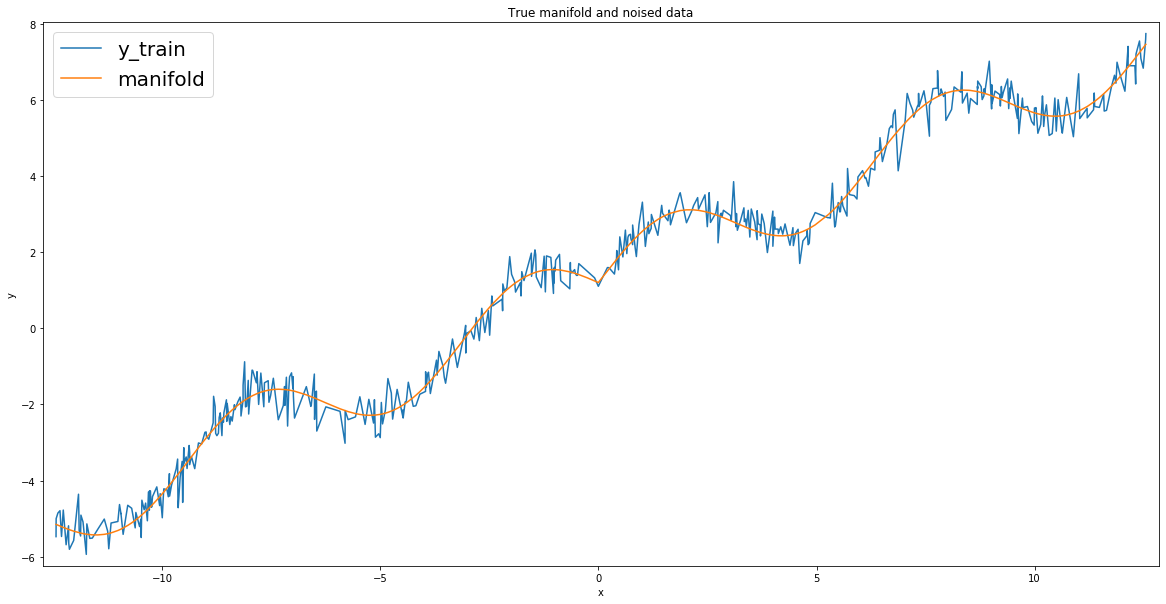

In [9]:
margin = 0.3
plt.figure(figsize=(20,10))

plt.plot(data['x_train'], data['y_train'], data['x_train'], data['manifold'])

plt.xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
plt.ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)

plt.legend(loc='upper left', prop={'size': 20}, labels=["y_train", "manifold"])
plt.title('True manifold and noised data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Метод наименьших квадратов (Ordinary Least Squares)


<font size=3>__Немного теории__</font>

Линейная регрессия позволяет прогнозировать значения количественного показателя в виде ___линейной комбинацией признаков___ с некоторыми весами. Поиск ___весов___ является целью обучения данного алгоритма, что достигается при помощи ___минимизации___ некоторого ___функционала ошибки___.

<font size=2.3>__Как строится предсказание?__</font>

Функция зависимости $y$ от $x$ будет иметь следующий вид $y_i=\sum_{j=1}^m{w_jx_{ij}}+w_{0}+\epsilon_i$, что и является ___линейной комбинацией признаков___. Обобщить данное выражение можно с помощью добавления фиктивной переменной $x_0=1$ (bais). И тогда в матричном виде получаем:

<font size=4>$$y=Xw+\epsilon$$</font>
где:
- $w$ $-$ оценка коэффициентов регрессии
- $X$ $-$ матрица наблюдений состоящая из $n$ строк и $m+1$ столбцов (вопрос в студию: почему +1?) - Ответ в студию: чтобы матричная запись была удобная, в матрицу $X$ добавляют const столбец из "1", которые при умножении на свободный член, его не изменят
- $\epsilon$ $-$ случайная ошибка модели

<font size=2.3>__Как найти "подходящие" веса?__</font>


Метод наименьших квадратов один из способов их поиска, в рамках которого используется __среднеквадратичная ошибка__

<font size=4>\begin{array}{rcl}\mathcal{L}\left( X, {y}, {w} \right) &=& \frac{1}{2n} \sum_{i=1}^n \left(y_i - {w}^\text{T} {x}_i\right)^2 \\
&=& \frac{1}{2n} \left\| {y} -  X {w} \right\|_2^2 \\
&=& \frac{1}{2n} \left({y} -  X {w}\right)^\text{T} \left({y} -  X {w}\right)
\end{array}</font>


Для решения задачи оптимизации необходимо взять производную по весам $w$ и прировнять ее к нулю:

\begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial {w}} &=& \frac{1}{2n} \left( {y}^{\text{T}} {y} -2{y}^{\text{T}} {X} {w} + {w}^{\text{T}} {X}^{\text{T}} {X} {w}\right) \\
&=& \frac{1}{2n} \left(-2 {X}^{\text{T}} {y} + 2{X}^{\text{T}} {X} {w}\right)
\end{array}


\begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial {w}} = 0 &\Leftrightarrow& \frac{1}{2n} \left(-2 {X}^{\text{T}} {y} + 2{X}^{\text{T}} {X} {w}\right) = 0 \\
&\Leftrightarrow& -{X}^{\text{T}} {y} + {X}^{\text{T}} {X} {w} = 0 \\
&\Leftrightarrow& {X}^{\text{T}} {X} {w} = {X}^{\text{T}} {y} \\
\end{array} 

<font size=4>$$ {w} = \left({X}^{\text{T}} {X}\right)^{-1} {X}^{\text{T}} {y}$$ </font>

Решение, полученные МНК, имеет наименьшую дисперсию среди всех линейных и несмещенных оценок, при условии выполнения 
[теоремы Гаусса - Маркова](https://ru.wikipedia.org/wiki/Теорема_Гаусса_—_Маркова).

Также эту задачу можно решать численно с помощью градиентного спуска, об этом речь пойдет дальше.

<font size=3 color="green">__Задание №1: Аналитическое решение МНК__</font>

__В данном задании вам необходимо реализовать 2 функции:__
- __least_squares_weights__: в рамках которой необходимо реализовать МНК подход к поиску коэфициентов регрессии. Функция должна возвращать одномерный numpy массив длины $m$, где $m$ $-$ число признаков матрицы $x$
- __least_squares_predict__: Функция должна возвращать одномерный numpy массив длины $n$, где $n$ $-$ число объектов матрицы $x$. Принимает на вход матрицу объекты-признаки $x$ и веса $w$. 

__!!ВАЖНО!!__: 
- не используйте в этих функциях циклы $-$ тогда она будет вычислительно неэффективной
- не изменяйте значения X_train и Y_train, иначе проверка не отработает (необходимо только в этом задании).


In [10]:
X_train = np.array([data['x_train']]).T
Y_train = data['y_train']

In [11]:
def least_squares_weights(x, y):
    w = np.linalg.inv(x.transpose().dot(x)).dot(x.transpose()).dot(y)
    return w

W = least_squares_weights(X_train, Y_train)

# TESTS
assert type(W) == np.ndarray, 'Возвращается не корректный тип'
assert W.shape == (1,), 'Проверьте размерность выходящего вектора'
assert round(W[0], 3) == 0.493, 'Не верно реализован расчёт весов'
assert time_delta(least_squares_weights, X_train, Y_train) < 1.5, 'Функция работает слишком долго, возможно вы используете лишние циклы'

In [12]:
def least_squares_predict(w, x):
    result = np.dot(x, w)
    return result

Y_train_predict = least_squares_predict(W, X_train)

# TESTS
assert type(Y_train) == np.ndarray, 'Возвращается не корректный тип'
assert Y_train_predict.shape == (500,), 'Проверьте размерность выходящего вектора'
assert round(Y_train_predict[123], 3) == -3.706, 'Не верно реализован расчёт весов'
assert time_delta(least_squares_predict, W, X_train) < 1.5, 'Функция работает слишком долго, возможно вы используете лишние циклы'

### Errors

<font size=3 >__Немного теории__</font>

Мы разберем __основные метрики качества и функционалы потерь__ задачи регрессии. Далее все будем называть __метриками__.

__Метрики необходимы для:__
- поиска оптимального решения
- оценки качества работы модели
- сравнения моделей
- интерпретации результатов



<table border="1" width="100%">
 <tr>
    <td width="50%"> 
        <p> <font size=3> $MAE= \frac{1}{n} \sum_{i=1}^n |y_i-\hat{y_i}|$  </font> </p> 
        <p> 
            <font size=2> 
                <span style="color:green; margin-left:2em">$ +$ </span>
                легко интерпретировать 
            </font><br/>
            <font size=2> 
                <span style="color:green; margin-left:2em">$ +$ </span>
                единицы измерения таргета и метрики – эквивалентны
            </font><br/>
            <font size=2> 
                <span style="color:green; margin-left:2em">$ +$ </span>
                устойчива к выбросам 
            </font><br/>
            <font size=2> 
                <span style="color:red; margin-left:2em">$ -$ </span>
                не ограничена сверху 
            </font><br/>
            <font size=2> 
                <span style="color:red; margin-left:2em">$ -$ </span>
                не дифференцируема в таком виде 
            </font>
        </p><br/>
        <p> <font size=3> $MSE= \frac{1}{n} \sum_{i=1}^n (y_i-\hat{y_i})^2$  </font> </p> 
        <p> 
            <font size=2> 
                <span style="color:green; margin-left:2em">$ +$ </span>
                дифференцируема
            </font><br/>
            <font size=2> 
                <span style="color:green; margin-left:2em">$ +$ </span>
                чувствительна к выбросам
            </font><br/>
            <font size=2> 
                <span style="color:red; margin-left:2em">$ -$ </span>
                не ограничена сверху 
            </font><br/>
            <font size=2> 
                <span style="color:red; margin-left:2em">$ -$ </span>
                сложно интерпретировать 
            </font><br/>
        </p><br/>
        <p> <font size=3> $RMSE=\sqrt{\frac{1}{n} \sum_{i=1}^n (y_i-\hat{y_i})^2} $  </font> </p> 
        <p> 
            <font size=2> 
                <span style="color:green; margin-left:2em">$ +$ </span>
                дифференцируема
            </font><br/>
            <font size=2> 
                <span style="color:red; margin-left:2em">$ -$ </span>
                не ограничена сверху 
            </font><br/>
            <font size=2> 
                <span style="color:red; margin-left:2em">$ -$ </span>
                еще сложнее интерпретировать 
            </font>
        <p>Основное различие $RMSE$ и $MAE$ заключается в том, что минимизация $RMSE$ сремиться к средней оценке, а  $MAE$ к медиане</p><br/><p>$y$ $-$ истинное значение; $\hat{y}$ $-$ предсказанное значение</p>
        </p><br/>
     </td>
    <td><img src="./errors_2.png" align="right"></td>
 </tr>
</table>

Две попытки __объединить__ положительные __свойства метрик__:
- [Функция потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss): 
    * ведет себя как $MSE$ на ошибках меньше $\sigma$ и как $MAE$ в противном случае. __Что не дает "взрываться" метрике на больших значениях и "жестко" реагирует на маленькие остатки__
    * все так же не удобно дифференцировать
- [Log-Cosh Loss](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0):
    * принимает меньшие значения по сравнению с функцией потерь Хьюбера на всем множестве
    * __дважды дифференцируема__, что необходимо в некоторых методах численной оптимизации.
________________________
__Проблема:__ все предыдущие метрики __не подходят для оценки конкретного решения__ а только для сравнения моделей, что следует из того что __функции не ограничены сверху.__ 

Эта проблема так же решается посредством доработок $MAE$: [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) и [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error). Однако, подробно рассмотрим метрику $R^2$
и мотивы появления $R^2_{adj}$.

$$R^2=1-\frac{\sum_{i=1}^n (y_i-\hat{y_i})^2}{\sum_{i=1}^n (y_i-\bar{y_i})^2}$$

Данная метрика обладает следующими свойствами:

<font size=2> 
    <span style="color:green; margin-left:2em">$ +$ </span>
     ограничена сверху и снизу, что позволяет дать оценку конкретному решению без сравнения с другими
</font><br/>
<font size=2> 
    <span style="color:green; margin-left:2em">$ +$ </span>
     хорошо интерпретируется: на сколько наша модель лучше, чем константное решение
</font><br/>
<font size=2> 
    <span style="color:red; margin-left:2em">$ -$ </span>
     не диффиренцируема
</font><br/>
<font size=2> 
    <span style="color:red; margin-left:2em">$ -$ </span>
     значение метрики растет (не уменьшается) при добавлении новых переменных, даже если они никак не объясняют целевой показатель. Поэтому нельзя сравнивать модели с разным количеством признаков. Данная проблема решается с помощью $R^2_{adj}$
</font>

$$R^2_{adj}=1-(1-R^2)\frac{n-1}{n-p-1}$$

где $p -$ число признаков, а $n -$ количество объектов

__Рекомендации:__ использовать $R^2_{adj}$ для сравнения моделей и оценки количества переменных, а $R^2$ для оценки качества на новых объектах

<font size=3 color="green">__Задание №2: Метрики качества__</font>

__В данном задании вам необходимо реализовать 4 основные метрики:__ $MAE; MSE; RMSE; R^2$

Каждая из метрик принимает на вход 2 одномерных numpy массива:
- __y_true__ - истинные значения 
- __y_predict__ - предсказанные значения

Каждая из функций должна возврашать одно число 

__!!ВАЖНО!!__: не используйте в этих функциях циклы $-$ тогда она будет вычислительно неэффективной.

In [13]:
def MAError(y_true, y_predict):
    error = abs(y_true-y_predict).sum() / y_true.shape[0]
    return error

def MSError(y_true, y_predict):
    error = ((y_true-y_predict)**2).sum() / y_true.shape[0]
    return error

def RMSError(y_true, y_predict):
    error = np.sqrt(((y_true-y_predict)**2).sum() / y_true.shape[0])
    return error

def R_square(y_true, y_predict):
    error = 1 - ((y_true-y_predict)**2).sum() / ((y_true - y_true.mean())**2).sum()
    return error

def all_metric(y_true, y_predict):
    d = {}
    d['MAE'] = [MAError(y_true, y_predict)] 
    d['MSE'] = [MSError(y_true, y_predict)] 
    d['RMSE'] = [RMSError(y_true, y_predict)]
    d['R_square'] = [R_square(y_true, y_predict)]
    return d

# TESTS
assert round(MAError(y_true=Y_train, y_predict=Y_train_predict), 3) == 1.274, 'Не верно реализован расчёт'
assert time_delta(MAError, Y_train, Y_train_predict) < 1.5, 'Функция работает слишком долго, возможно вы используете лишние циклы'

assert round(MSError(y_true=Y_train, y_predict=Y_train_predict), 3) == 2.22, 'Не верно реализован расчёт'
assert time_delta(MSError, Y_train, Y_train_predict) < 1.5, 'Функция работает слишком долго, возможно вы используете лишние циклы'

assert round(RMSError(y_true=Y_train, y_predict=Y_train_predict), 3)== 1.49, 'Не верно реализован расчёт'
assert time_delta(RMSError, Y_train, Y_train_predict) < 1.5, 'Функция работает слишком долго, возможно вы используете лишние циклы'

assert round(R_square(y_true=Y_train, y_predict=Y_train_predict), 3)== 0.843, 'Не верно реализован расчёт'
assert time_delta(R_square, Y_train, Y_train_predict) < 1.5, 'Функция работает слишком долго, возможно вы используете лишние циклы'

<font size=3, color="green">__Задание №0.2: визуализация__</font>

Визуализируйте зависимость _y_train_ от _x_train_; значения _manifold_; а так же предсказанные значения для каждой точки

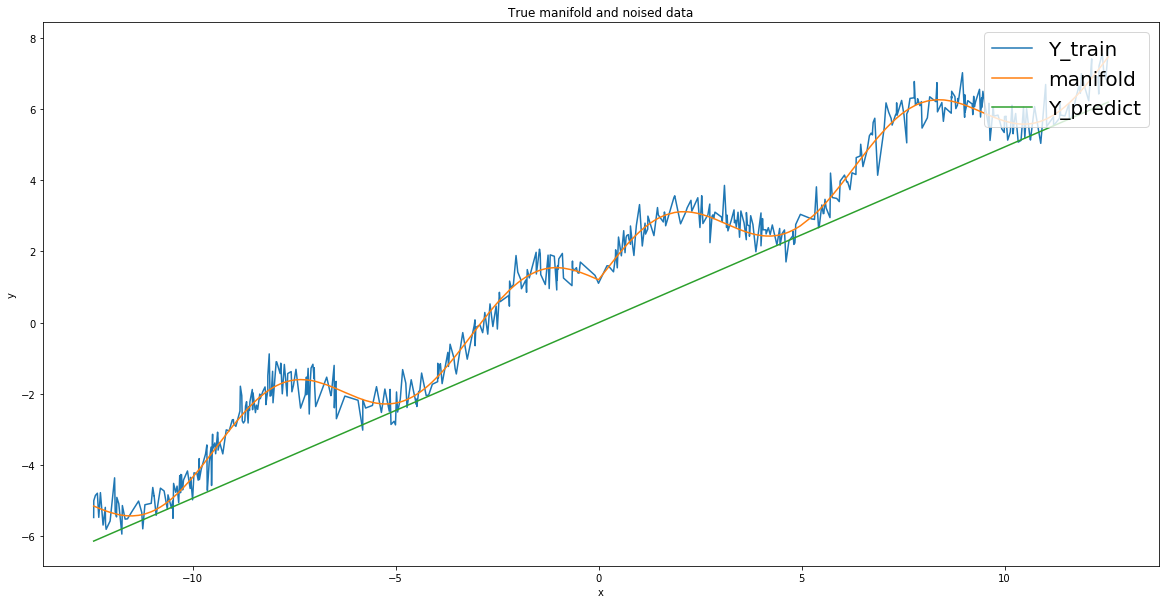

In [14]:
plt.figure(figsize=(20,10))

plt.plot(X_train, Y_train, X_train, data['manifold'], X_train, Y_train_predict)

plt.legend(loc='upper right', prop={'size': 20}, labels=['Y_train', 'manifold', 'Y_predict'])
plt.title('True manifold and noised data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<font size=3, color="green">__Задание №3: Улучшить модель__</font>

Если все сделано верно, то ваш текуший результат $R^2 \approx 0.84$, что в целом неплохо, но из графика видно, что можно лучше.

_Сообщите, если это нет так_

__Цель:__ Улучшить результат, оставив линейный характер предсказания. Кажется, что это можно сделать, добавив лишь один признак.

In [15]:
X_train_ = np.hstack((X_train, np.ones(X_train.shape)))
W_new = least_squares_weights(X_train_, Y_train)
Y_train_predict_new = least_squares_predict(W_new, X_train_)

assert round(R_square(y_true=Y_train, y_predict=Y_train_predict_new), 3) >= .95, 'можно лучше'
assert X_train_.shape[1] == 2, 'должно быть 2 признака'

### Полиномиальная регрессия

Ленейная модель требует линейную зависимость между целевой и объясняющей переменной, что часто нет так. Однако можно "скривить" предсказание.

<font size=3 >__Немного теории__</font>

Что бы __увеличить сложность модели__ нам необходимо увеличить сложность признаков. В общем случае мы переходим от __линейного уровнения к полиному__:

$$Y=w_0+w_1x \Rightarrow Y=w_0+w_1x+w_2x^2$$

Это __все еще линейная модель__ так как веса все еще линейны. $x^2$ всего лишь признак описывающий квадратичную зависимость $y$ от $x$.

В целом, не обязательно нужно брать полиномы. Можно накладывать любую нелинейную функцию, а также функции от нескольких переменных, если у нас более одной описывающей переменной.

<font size=3, color="green">__Задание №4: Полиномиальная регрессия__</font>

В данном задании вы увидите поведение предсказания и метрик качества в зависимости от степени полинома. Исходная функция предсказания примет следующий вид:
   
   $$Y=w_0+\sum_{j=1}^nw_jx^j$$

__Цель__: Реализовать __код или функцию__, которая будет вызываться в уже написанном цикле, принимать на вход размер полинома (значение из degree_variance) и значения $X$ и возвращать пространство соответствующего размера.


__!!ВАЖНО!!__: 
- большая часть кода уже написана, не стоит ее менять
- не забывайте $w_0$ (bais вектор), сделать это необхомо посредством добавления фиктивной переменной

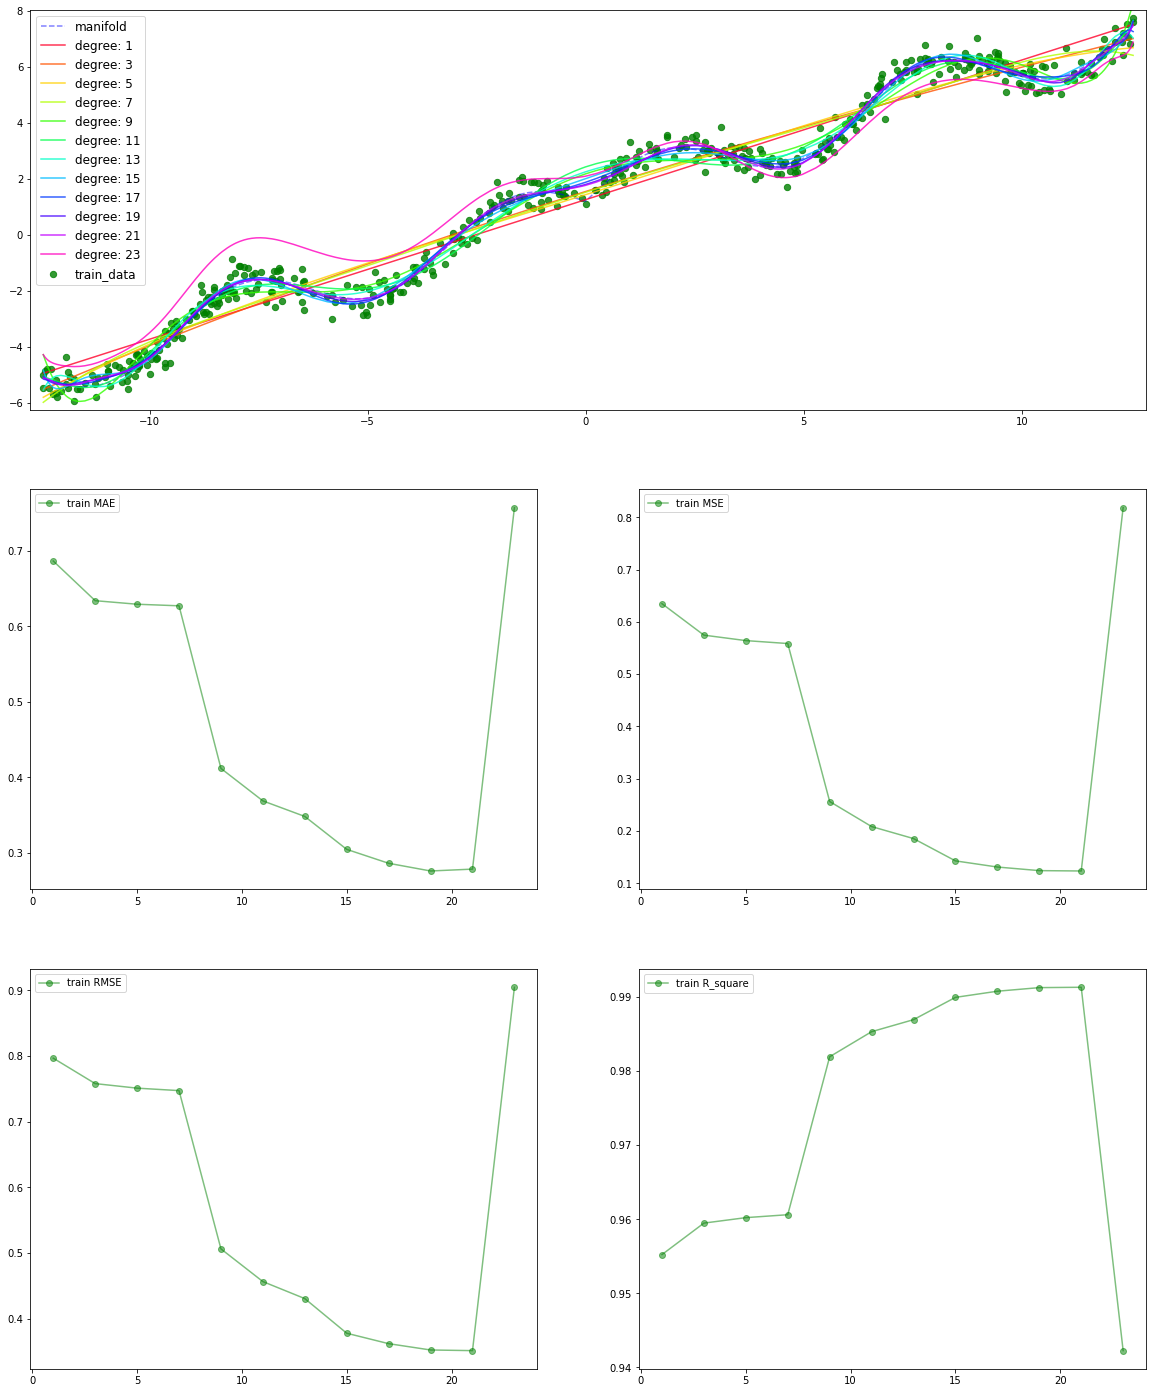

In [16]:
degree_variance = range(1,24, 2)
train_errors, test_errors = {}, {}

# PLOT SET
fig = plt.figure(figsize=(20, 25))
colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,len(degree_variance))]

ax1 = plt.subplot(311)
ax1.plot(data['x_train'], data['manifold'], 'b--', alpha=0.5, label='manifold')
ax1.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='train_data')
ax1.set_xlim(data['x_train'].min() - margin, data['x_train'].max() + margin)
ax1.set_ylim(data['y_train'].min() - margin, data['y_train'].max() + margin)

for i, v in enumerate(degree_variance):
 
    # TRAIN
    X_train = np.array([data['x_train'] ** k for k in range(v+1)]).T
    

    assert X_train.shape[1] == 1+v, 'Количество признаков определяется как степень полинома + basi'
    
    
    Y_train = data['y_train']

    # PREDICT
    W = least_squares_weights(X_train, Y_train)
    Y_train_predict = least_squares_predict(W, X_train)
    
    # PLOT SOLUTION
    ax1.plot(data['x_train'], Y_train_predict, color = colors[i], alpha=0.8, label='degree: {}'.format(v))   
    ax1.legend(loc='upper left', prop={'size': 12})
    
    # ERRORS
    train_errors = merge_two_dicts(train_errors, all_metric(Y_train, Y_train_predict))

# PLOT ERRORS
for i, key in enumerate(train_errors.keys()):
    plt.subplot(3,2,i+3)
    plt.plot(degree_variance, train_errors[key], 'go-', alpha=0.5, label='train {}'.format(key));
    plt.legend()


In [17]:
assert len(train_errors['MAE']) == 12, 'степеней полинома должно быть 12 как указано в коде'
assert sum(map(lambda i: train_errors['R_square'][i]>train_errors['R_square'][i-1], range(1, 12))) == 10, 'на каждой итерации, кроме последней, значение метрики должно расти по сравнению с предыдущей'

## Многомерный случай

Далее будем работать с новыми данными. Теперь у нас 15 описывающих показателей.

__!!ВАЖНО!!__: Добавлять bias не нужно. В данных уже есть переменная $X_{14}=1$, вес при которой, будет отвечать за bias

In [18]:
np.random.seed(0) 

X_train, Y_train, X_test, Y_test = read_task_2_3('./task_2.csv')

X_train.shape, X_test.shape

((7000, 15), (3000, 15))

### линейно зависимые признаки

Воспользуемся функциями из предыдущих заданий и посчитаем веса и метрики для многомерного случая

In [19]:
W = least_squares_weights(X_train[:,:], Y_train)

Y_train_predict = least_squares_predict(W, X_train[:,:])
Y_test_predict  = least_squares_predict(W, X_test[:,:])


# все ОК аналитическое решение работает 
print([round(i, 2) for i in W])
print(all_metric(Y_train, Y_train_predict))
print(all_metric(Y_test, Y_test_predict))

[-1949.38, -0.05, 1299.66, -8.19, 90.0, 0.0, 16.23, 23.23, 91.42, 99.11, 0.0, -20.06, 10.64, 6.02, 0.29]
{'MAE': [5.585287892376245], 'MSE': [49.376522168598086], 'RMSE': [7.0268429730995186], 'R_square': [0.998183386306156]}
{'MAE': [5.6864633857595415], 'MSE': [50.48895088937429], 'RMSE': [7.105557746537163], 'R_square': [0.9980554950001325]}


$R^2$ почти идеальный, но, кажется, что остальные метрики могут быть лучше

Признаки не должны быть скоррелированны $-$ одно из необходимых условий для получения оптимальных несмещенных оценок c помощью МНК. Напомню, что данное требование вытекает из [теоремы Гаусса - Маркова](https://ru.wikipedia.org/wiki/Теорема_Гаусса_—_Маркова).

Давайте проверим, выполняется ли это условие в нашем случае. Рассчитаем значение [корреляции Пирсона](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) для каждой пары признаков.

$$\rho_{x_ix_j}=\frac{\sum_{k=1}^n(x_i-\bar{x_i})(x_j-\bar{x_j})}{\sqrt{\sum_{k=1}^n(x_i-\bar{x_i})^2\sum_{k=1}^n(x_j-\bar{x_j})^2}}$$

__где__,

- $i, j$ $-$ индексы признаков
- $k$ $-$ индекс объекта

<font size=3, color="green">__Задание №5: Корреляция__</font>

Релизовать функцию __correlation_matrix__:

- __вход:__ матрица объекты-признаки ($X$) размером $m\times n$, где $m -$ количество объектов; $n -$ количество признаков
- __выход:__ матрица, заполненная значениями корреляции Пирсона
    - матрица квадратная
    - симметричная матрица
    - значение элемента выходной матрицы $a_{ij} - $ значение корреляции Пирсона $i$-ом и $j$-ом признаком 
    - корреляция не может быть расчитана, когда один из признаков константный
   
__!!ВАЖНО!!__: не стоит реализовывать функцию "в лоб" поищите ответ в numpy

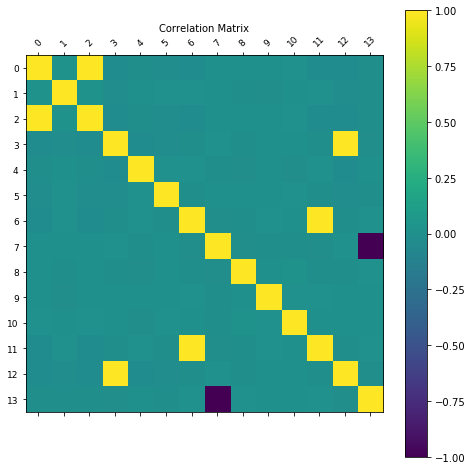

In [20]:
def correlation_matrix(x):
    result = np.corrcoef(x[:, :-1].T)
    return result

corr_matrix = correlation_matrix(X_train)

#TESTS
assert type(corr_matrix) == np.ndarray, 'Возвращается не корректный тип'
assert corr_matrix.shape[0] == corr_matrix.shape[1], 'Матрица не квадратная'
assert corr_matrix.shape[0] == 14, 'Выбраны не все необходимы показатели для матрицы корреляций или вы не убрали показатель, отвечающий за bais'
assert sum(map(lambda n: corr_matrix[n,n], range(0, corr_matrix.shape[0]))) == 14, 'Не диагональная матрица'
assert sum(map(lambda n, k: round(corr_matrix[n,k], 3)==round(corr_matrix[k,n],3), 
                   range(0, corr_matrix.shape[0]), 
                   np.random.randint(14, size=14))), 'Матрица не симметрична'

# Визуализация матрицы
plot_correlation_matrix(corr_matrix)

Как видно из графика выше, некоторые признаки сильно скоррелированы друг с другом. 

<font size=3, color="green">__Задание №5.1: очистить лишнее__</font>

Создайте 2 новые переменные __X_train_new__ и __X_test_new__ из __X_train__ и __X_test__, которые будут содержать только некоррелированные признаки. И обновите веса.

__Результат:__ обновленные значения метрик на train и test датасетах

In [21]:
drop = np.argwhere(np.triu(np.isclose(np.abs(corr_matrix),1),1))
X_train_new = np.delete(X_train[:,:-1],drop[:,1],axis=1)
X_test_new  = np.delete(X_test[:,:-1],drop[:,1],axis=1)

# TESTS
assert type(X_train_new) == np.ndarray, 'Возвращается не корректный тип'
assert type(X_test_new) == np.ndarray, 'Возвращается не корректный тип'
assert X_test_new.shape[1] == X_train_new.shape[1], 'Количество признаков в train и test различно'
assert X_test_new.shape[1] == 10, 'Количество признаков неверно'


# Обновление весов
W = least_squares_weights(X_train_new[:,:], Y_train)

Y_train_predict = least_squares_predict(W, X_train_new[:,:])
Y_test_predict  = least_squares_predict(W, X_test_new[:,:])

# TESTS
assert len(W) == 10, 'Количество весов неверно'
assert R_square(Y_train, Y_train_predict) > .98, 'Что-то пошло не так, метрики должны быть выше'
assert R_square(Y_test, Y_test_predict) > .98, 'Что-то пошло не так, метрики должны быть выше'

### T-test

__Вектор оценок весов $w$ является случайной величиной.__ 
Данный факт следует из аналитического решения $\left({X}^{\text{T}} {X}\right)^{-1} {X}^{\text{T}} {y}$, где $y$ так же случайная величина.

Вывод этого утверждения довольно неприятен, и был разобран на лекции. Сейчас важно, что оценки коэффициентов $w_i$ имеют асимптотически нормальное распределение. 

------

Данное свойство позволяет проверять гипотезу о равенстве коэффициента нулю.

$$H_0: w_i=0 \\ H_1: w_i\not=0$$

__Статистика $t$__ имеет [распределение Стьюдента](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0) с $n-k$ степенями свободы при справедливости $H_0$:

$$t=\frac{w_i}{se(w_i)}$$

__где__, 

- $n$ $-$ число объектов
- $k$ $-$ число признаков
- $se(w_i)$ $-$ стандартная ошибка $w_i$

значения $se(w_i)$ - корень из диагональных элементов ковариационной матрицы $\hat{Var}(w|X)$

$$\hat{Var}(w|X)=\hat\sigma^2({X}^{\text{T}} {X})^{-1}$$

__где__, $\hat\sigma^2$ является оценкой истинного значиния $\sigma^2$ и вычисляется

$$\hat\sigma^2=\frac{RSS}{n-k}=\frac{\sum_{i=1}^n(y_i-wx_i)^2}{n-k}$$

Таким образом, мы получили одновыборочный t-критерий Стьюдента. $\text{p_value}$ в данном случае вычисляется как:

$$\text{p_value}=2(1-cdf(t, df=n-k))$$

__где__,
$cdf(t, df=n-k)$ $-$ __значение функции распределения__ Стьюдента c $n-k$ степенями свободы в точке $t$.

________________

Большинство реализаций данного метода сами расчитывают значения $t$-статистики и $\text{p_value}$. Пример ниже:

In [22]:
from statsmodels.regression.linear_model import OLS
model = OLS(Y_train,X_train_new[:,:], random_seed = 2)
results = model.fit()

In [23]:
print('W OLS ', [round(i, 3) for i in results.params])
print('t-stat', [round(i, 3) for i in results.tvalues])
print('pvalue', [round(i, 3) for i in results.pvalues])

W OLS  [-0.005, 0.001, -0.001, 90.084, 0.008, 8.285, 11.354, 91.419, 99.104, -0.002]
t-stat [-1.505, 0.411, -0.435, 25514.753, 2.277, 7809.592, 3240.363, 25483.605, 27776.828, -0.609]
pvalue [0.132, 0.681, 0.664, 0.0, 0.023, 0.0, 0.0, 0.0, 0.0, 0.542]


In [24]:
print(W)

[-5.37156457e-03  1.45435183e-03 -1.42012413e-03  9.00843250e+01
  8.05707798e-03  8.28502058e+00  1.13536034e+01  9.14186799e+01
  9.91037253e+01 -2.17458791e-03]


Можете сверить значение весов, которые вы получили в предудыщих заданиях, с результатом работы матода OLS из пакета statsmodels. Если с точностью до 3-го знака все хорошо, то двигайся дальше, если нет, то что-то пошло не так.

<font size=3, color="green">__Задание №6: $\text{p_value}$__</font>

__В данном задании вам необходимо реализовать 3 функции и дать ответ на один вопрос:__
- __variance_matrix__: расчет ковариационной матрицы. 
    - _Вход_: признаковое пространство $X$, истинные значения меток $\text{y_true}$ и предсказанные значения $\text{y_predict}$
    - _Выход_: ковариационная матрица
    
    
- __t_values__: расчет $t$-статистики
    - _Вход_: массив весов $w$ и ковариационная матрица $\text{X_variance}$
    - _выход_: массив значений $t$-статистики для каждого из весов $w$
    
    
- __p_values__: расчет $\text{p_value}$
    - _Вход_: массив значений $t$-статистики для каждого из весов $w$ и количество степеней свободы $df$
    - _выход_: массив значений $\text{p_value}$-статистики для каждого из весов $w$
    
    
- Для скольких весов отвергается $H_0$ на уровне значимости $\alpha=0.05$?
    - Первый кто реализует все функции и скажет верный ответ, получит дополнительные баллы
    
__!!ВАЖНО!!__

- Задание считается решенным, если все три функции работают корректно
- Не используйте в этих функциях лишние циклы,  иначе они будут вычислительно неэффективными

In [25]:
def variance_matrix(X, y_true, y_predict):
    variance = ((y_true - y_predict)**2).sum() / (X.shape[0] - X.shape[1]) * np.linalg.inv(np.dot(X.T, X))
    return variance

vcov =  variance_matrix (X_train_new[:,:], Y_train, Y_train_predict)

#TESTS
assert type(vcov) == np.ndarray, 'Возвращается не корректный тип'
assert vcov.shape[0] == vcov.shape[1], 'Матрица не квадратная'
assert vcov.shape[0] == W.shape[0], 'Матрица не верного размера'
assert np.round(sum(map(lambda n: vcov[n,n], range(0, vcov.shape[0]))), 5) == 0.00011, 'Матрица рассчитана не корректно'
# проверка на необходимые библиотеки

In [26]:
def t_values(w, X_variance):
    result = w / np.array([np.sqrt(X_variance[i][i]) for i in range(X_variance.shape[0])])
    return result

t = t_values(W, vcov) 

assert type(t) == np.ndarray, 'Возвращается не корректный тип'
assert t.shape == W.shape, 'Размерность массива весов и массива t-статистик не совпадает'
assert [round(i, 3) for i in t] == [round(i, 3) for i in results.tvalues], 'Результат рассчитан некорректно'
# проверка на необходимые билиотеки

In [27]:
def p_values(t, df):
    result = 2 * (1 - stats.t.cdf(abs(t), df))
    return result

p = p_values(t, X_train_new.shape[0]-X_train_new.shape[1])

assert type(p) == np.ndarray, 'Возвращается не корректный тип'
assert p.shape == W.shape, 'Размерность массива весов и массива p_value не совпадает'
assert [round(i, 3) for i in p] == [round(i, 3) for i in results.pvalues], 'Результат рассчитан некорректно'

### Gradient descent

<font size=3>__Немного теории__</font>

У классического аналитического решения есть ряд недостатков:
1. расчет псевдообратной матрицы является довольно сложной операцией и работает долго на больших объемах данных
2. данный метод требует выполнения уловий [теоремы Гаусса - Маркова](https://ru.wikipedia.org/wiki/Теорема_Гаусса_—_Маркова) иначе оценки будут смещенными.

__Градиентный спуск__

Способ решить задачу численно. Нивелирует недостатки аналитического решения, однако не дает возможности вычислять значимость весов\коэффициентов регрессии.

В общем случае в процессе обучения, с помощью градиентного спуска, веса обновляются следующим образом:

$$w^{n+1}_i=w^{n}_i-\gamma\bigtriangledown L(w^{n}_i)$$

__где__,

- $n$ $-$ индекc итерации
- $i$ $-$ индекc признака
- $\gamma$ $-$ величина шага градиентного спуска
- $\bigtriangledown F(w^{n}_i)$ $-$ значение [градиентда](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82) функции потерь для $i$-го веса на шаге $n$

__Недостаток градиентного спуска:__ На каждой итерации $n$ необходимо рассчитывать значение градиента для каждого объекта выборки. __Стохастический градиентный спуск__ является альтернативой. Единственное отличительное свойство: на каждой итерации градиент рассчитывается только на одном объекте, иногда на нескольких объектах.

<font size=3, color="green">__Задание №:7 Градиентный спуск__</font>

__Цель:__ Релизовать метод стахостического градиентного спуска для решения задачи линейной регрессии с квадратичной функцией потерь и отследить процесс обучения с помощью визуализации.

$$ L(y,X,w)=\frac{1}{n} \sum_{i=1}^n (y_i-Xw)^2$$

Для решения этой задачи понадобится две функции, одна из которых уже полностью реализована

функция __fit уже реализована__ и отвечает за:
1. первичную инициализацию весов
2. итерационное обновление весов (__iters__ - количество итераций)
    - семплирует __batch_size__ элементов из исходного множества объектов. Обратите внимание, что объектов > 1 на каждой итерации
    - вызывает функцию расчета градиента для заданных объектов (__stochastic_gradient_step__)
3. визуализацию обучения (__plot__=True)

__Вход__: матрица объект-признак $X$ и истинные значения $y$; значения весов, полученных аналитическим методом  $\text{analytical_w}$

__Выход__: значения весов $w$ на последней итерации стохастического градиентного спуска и значения весов при аналитическом решении
_________

__Вам необходимо:__ реализовать функцию __stochastic_gradient_step__, цель которой рассчитать значение градиента по каждому из весов на заданных объектах.

__Вход:__

- $w$ $-$ значения весов с предыдущего шага
- $X$ $-$ матрица объект-признак, размера ($\text{batch_size}$, $N$). $N$ $-$ число признаков
- $y$ $-$ вектор истинных значений $y$ длины $\text{batch_size}$

__Выход:__ вектор значений градиента для каждого из весов



<IPython.core.display.Javascript object>


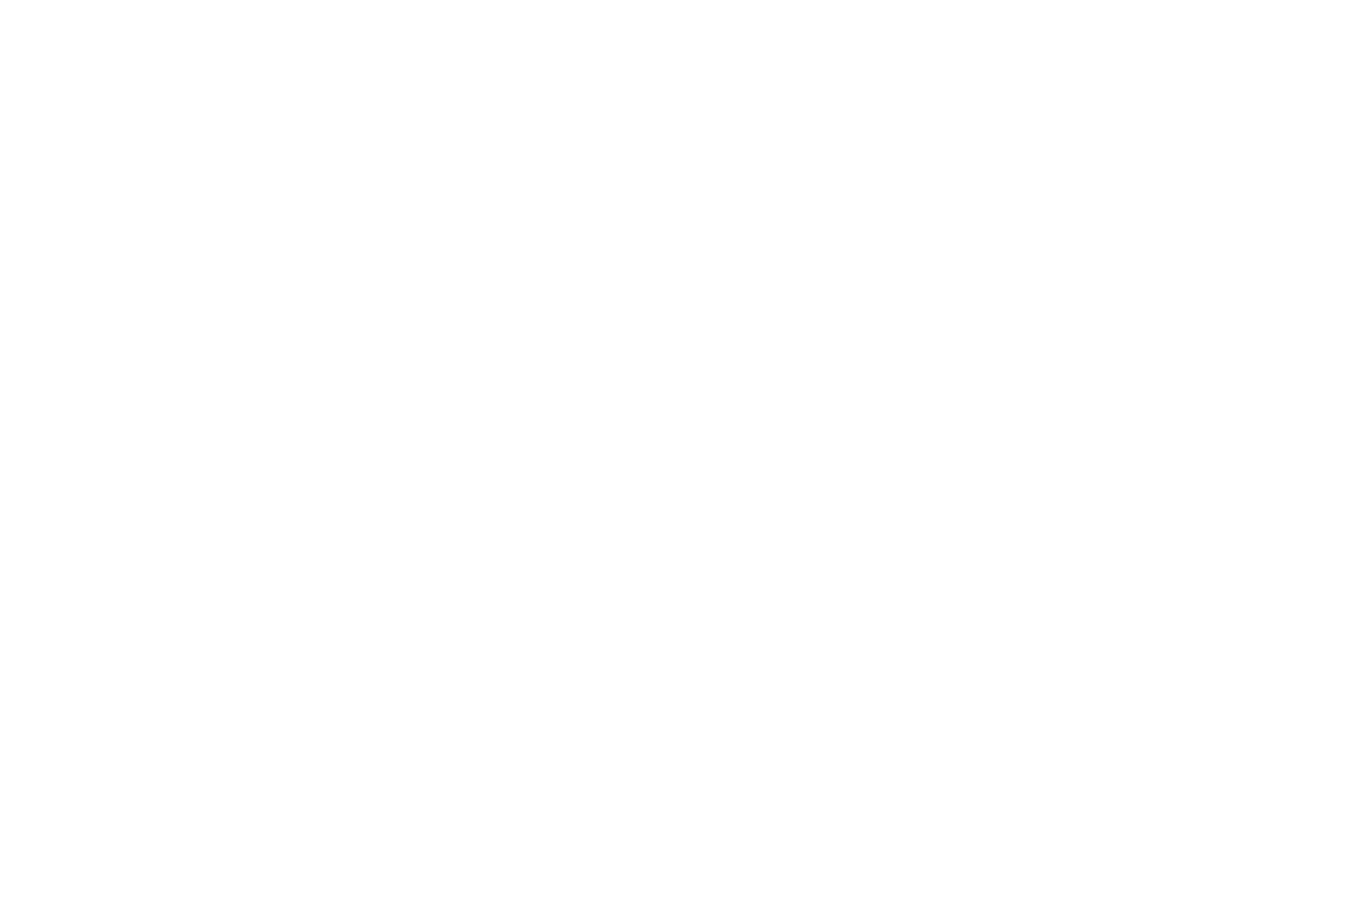

<IPython.core.display.Javascript object>


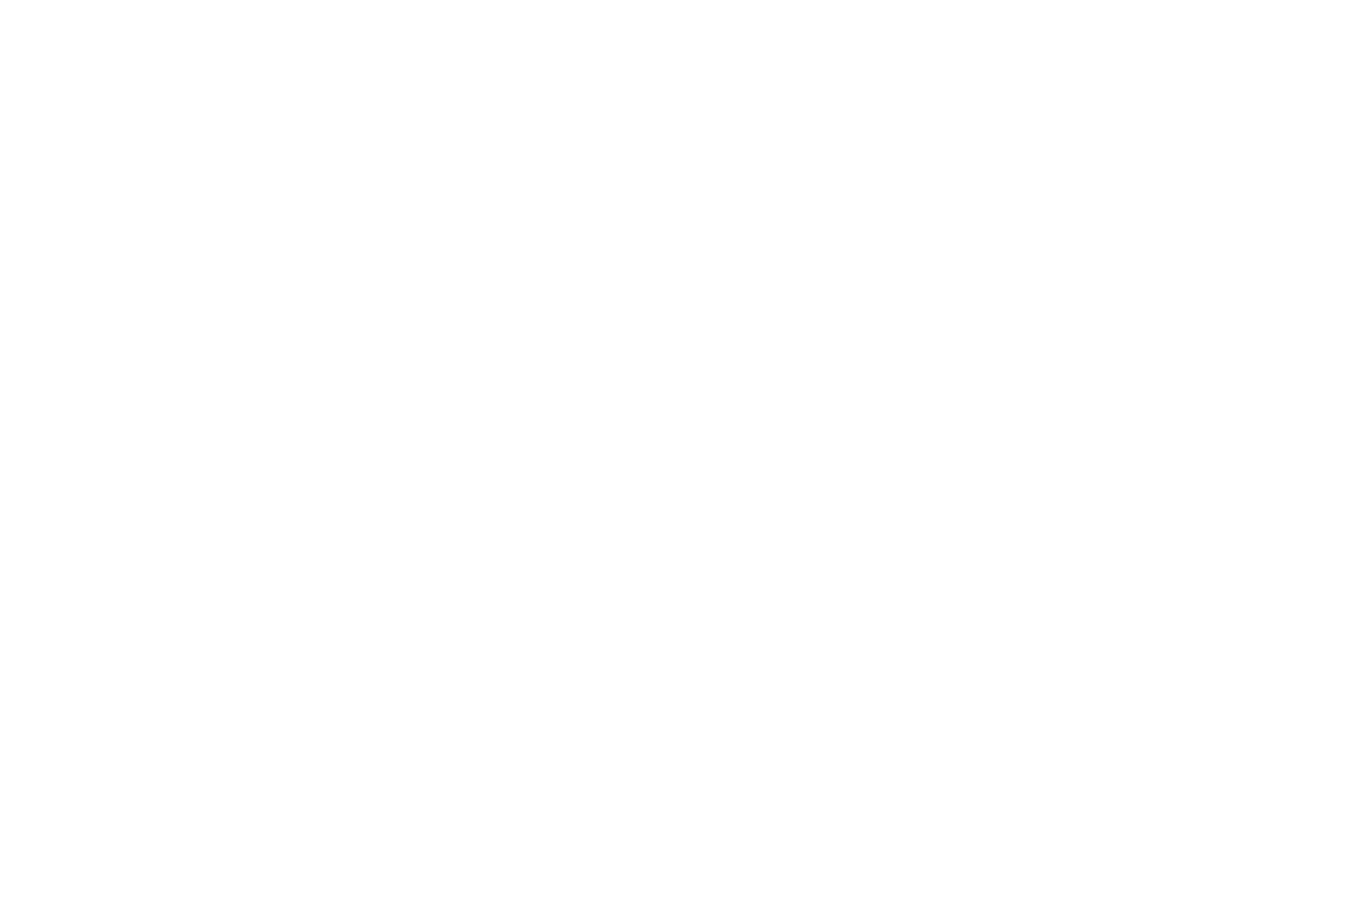

In [28]:
%matplotlib notebook

def stochastic_gradient_step(w, X, y):
    grad = 2./ X.shape[0] * np.dot(X.T, (least_squares_predict(w, X) - y))
    return grad   



def fit(X, y, analytical_w, random_state=42, iters=100, batch_size=10, learning_rate=0.05, plot=True):
    random_gen = np.random.RandomState(random_state)
    errors = []
    
    
    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    w = random_gen.rand(dim)
    
    weights_history = w
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        # берём случайный набор элементов
        rand_indices = random_gen.choice(size, batch_size)
        X_ = X[rand_indices]
        y_ = y[rand_indices]

        # считаем производные
        grad = stochastic_gradient_step(w, X_, y_)
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(w), 'длина вектора должна быть равной количеству весов'
        
        w   -= grad * learning_rate
        
        # Обновляем веса
        weights_history = np.vstack((weights_history, w))
        
        # error
        predict = least_squares_predict(w, X)
        errors.append(R_square(y, predict))
        
        if plot:
            ax1.clear()            
            ax1.plot(range(dim), analytical_w, 'bo-', label='Analytical solution')
            ax1.plot(range(dim), w, 'ro-', label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('weights')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('R_square')
            ax2.set_xlabel('itarations')
            
            ax3.plot(weights_history)
            ax3.set_title('update weights')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            
            time.sleep(0.3)
            fig.canvas.draw()   
            
    return w, analytical_w

# X_train_new матрица объект-признаки, полученная после выполнения задания №5.1:
# должно быть 10 признаков

w_SGD, w_OLS = fit(X_train_new, Y_train, analytical_w=W, plot=True)

Y_test_predict_OLS  = least_squares_predict(w_OLS, X_test_new[:,:])
Y_test_predict_SGD  = least_squares_predict(w_SGD, X_test_new[:,:])


assert .98 <= R_square(Y_test, Y_test_predict_OLS)/R_square(Y_test, Y_test_predict_SGD) <= 1.02, 'задание решено не верно'

<font size=3>__Немного теории__</font>

Решение методом градиентного спуска имеет ряд недостатков:
1.	Решение получается не стабильным и переобученным в случае наличие коррелированных признаков. Градиент стремится завышать веса таких признаков, «игнорируя» другие признаки
2.	Данный метод не предполагает наличие незначимых признаков и стремиться выдать им хоть какой-то вес тем самым модель становиться менее устойчивой 

Решить эти проблемы можно с помощью регуляризаторов:
- __$L2$ Rige regression.__ Штрафует за сильно высокие веса, стремясь уменьшить эффект 1-ой проблемы.

$$L(y,X,w)=\frac{1}{n} \sum_{i=1}^n (y_i-Xw)^2+\delta\sum_{j=1}^pw_i^2$$ 
где $n$ $-$ количество объектов; $p$ $-$ количество признаков; $\lambda$ $-$ коэффициент регуляризации

- __$L1$ Lasso.__ Стремится обнулить наибольшее количество весов. Таким образом решается 2-ая проблема

$$L(y,X,w)=\frac{1}{n} \sum_{i=1}^n (y_i-Xw)^2+\lambda\sum_{j=1}^p|w_i|$$ 

где $n$ $-$ количество объектов; $p$ $-$ количество признаков; $\delta$ $-$ коэффициент регуляризации

- __ElasticNet.__ Обобщенная форма $L1$ и $L2$

$$L(y,X,w)=\frac{1}{n} \sum_{i=1}^n (y_i-Xw)^2+\alpha\gamma\sum_{j=1}^p|w_i|+0.5\alpha(1-\gamma)\sum_{j=1}^pw_i^2$$ 

Если при условии простого суммирования $\lambda\text{L1}+\delta\text{L2}$, то

$\alpha=\lambda+\delta$ $-$ общий множитель регуляризаторов. При $\alpha=0$ получаем исходную функцию потерь, без штрафов. 

$\gamma=\frac{\lambda}{\lambda+\delta}$ $-$ коэфициент вклада $L1$. Принимает значения от 0 до 1. При $\gamma=0 \rightarrow \text{ElasticNet}=L2$; $\gamma=1 \rightarrow \text{ElasticNet}=L1$

<font size=3, color="green">__Задание №:8 Градиентный спуск и регуляризация__</font>

Вам необходимо __переписать__ функцию __stochastic_gradient_step__ что бы она расчитывала значения градиентов для функции потерь __ElasticNet__.

__Вход:__   
- аналогично заданию №7
- alpha $(\alpha)$ $-$ общий множитель регуляризаторов 
- l1_ratio $(\gamma)$ $-$ коэфициент вклада $L1$

__Выход:__ вектор значений градиента для каждого из весов

__!!ВАЖНО!!__: 

- Посмотрите на то как меняются веса при изменении параметра $\text{l1_ratio}$
- Функция __fit__ останется прежней

<IPython.core.display.Javascript object>


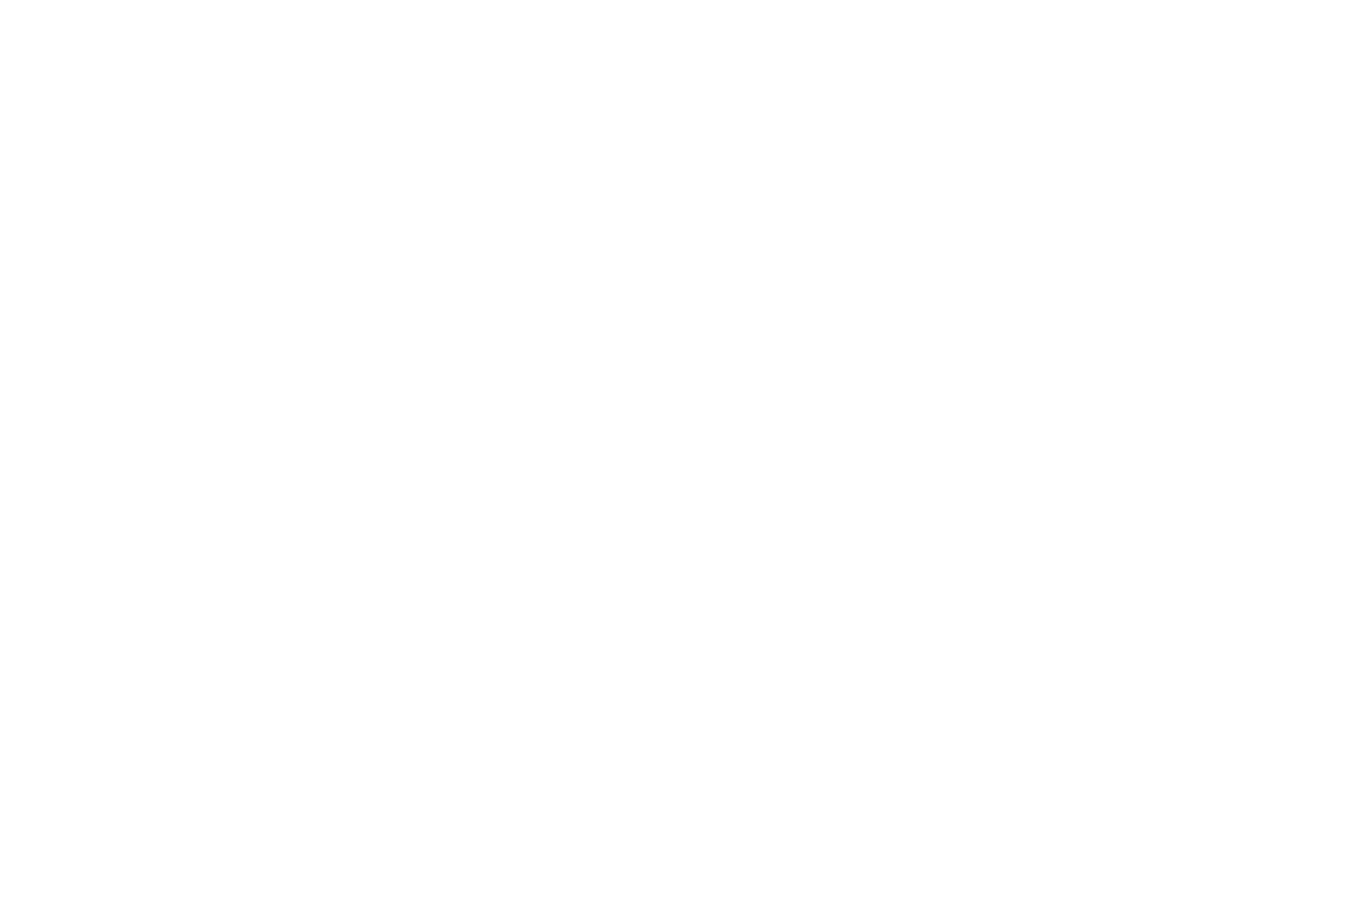

<IPython.core.display.Javascript object>


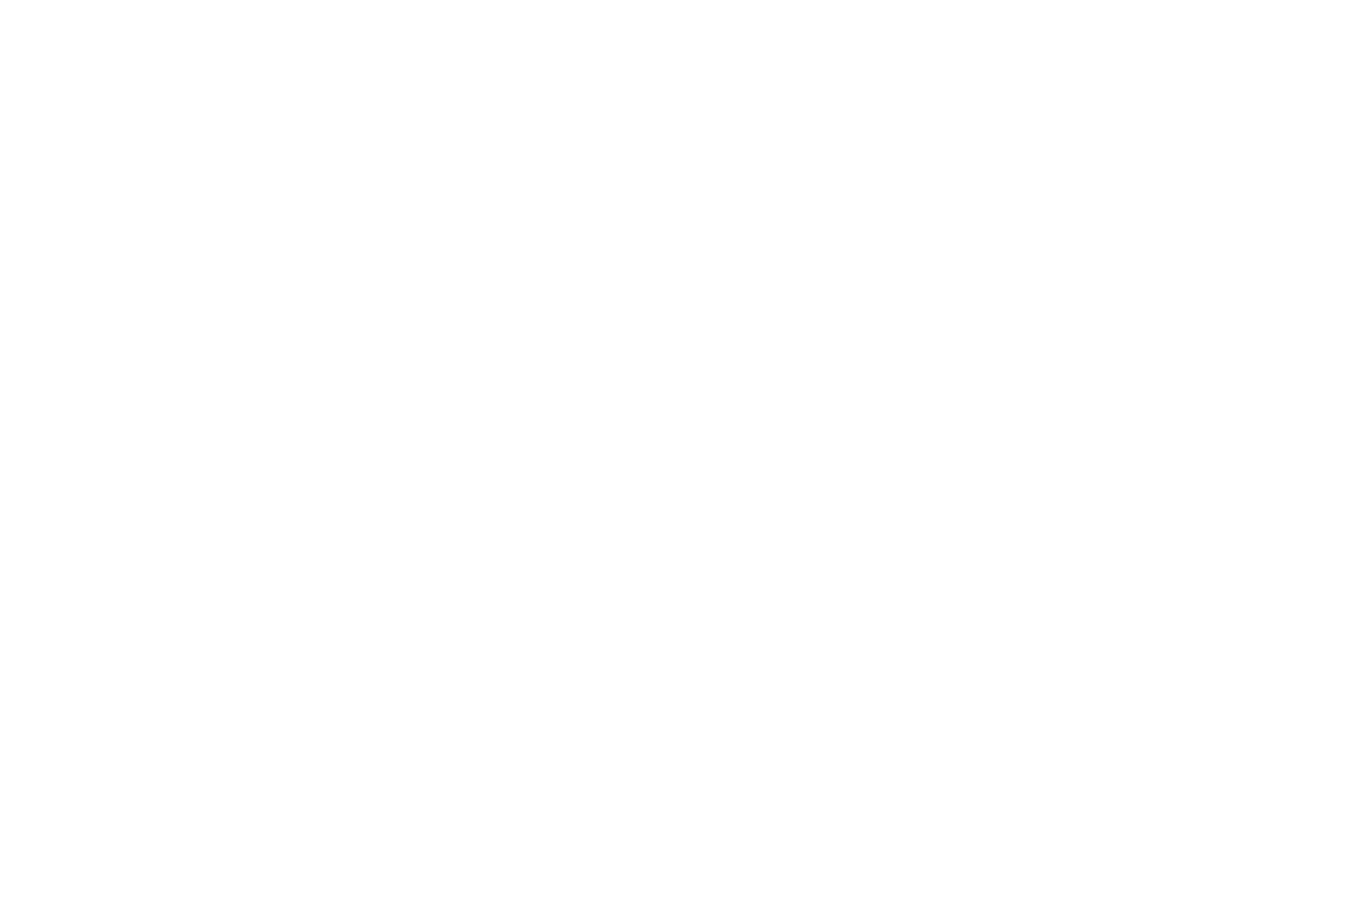

In [29]:
# Изменить код необходимы функций так что бы можно использовать как l1 так и l2 регуляризацию одновременно
# Как изменяются веса в краевых случаях
def stochastic_gradient_step(w, X, y, alpha=1, l1_ratio=0):
    grad = 2/X.shape[0] * np.dot(X.T, (least_squares_predict(w, X) - y)) + alpha * l1_ratio + alpha * (1 - l1_ratio) * w
    return grad 

# Будем обучаться на исходном множестве признаков (14)
# a_w - веса полученные аналитическим решением. Уменьшил некоторые сознательно, что бы график обучения был читабелен
a_w = [-8.21, 12.21, 7.38, 29.11, 34.44, 62.33, 12.95, 149.06, 91.42, 99.11, -0.0, -20.72, -41.53, 86.23, 1]
w = fit(X_train, Y_train, analytical_w=a_w)
# проверка!!!

# Classification

In [30]:
%matplotlib inline

In [31]:
X_train, Y_train, X_test, Y_test = read_task_2_3('./task_3.csv', bias=False)

X_train.shape, X_test.shape

((699, 2), (300, 2))

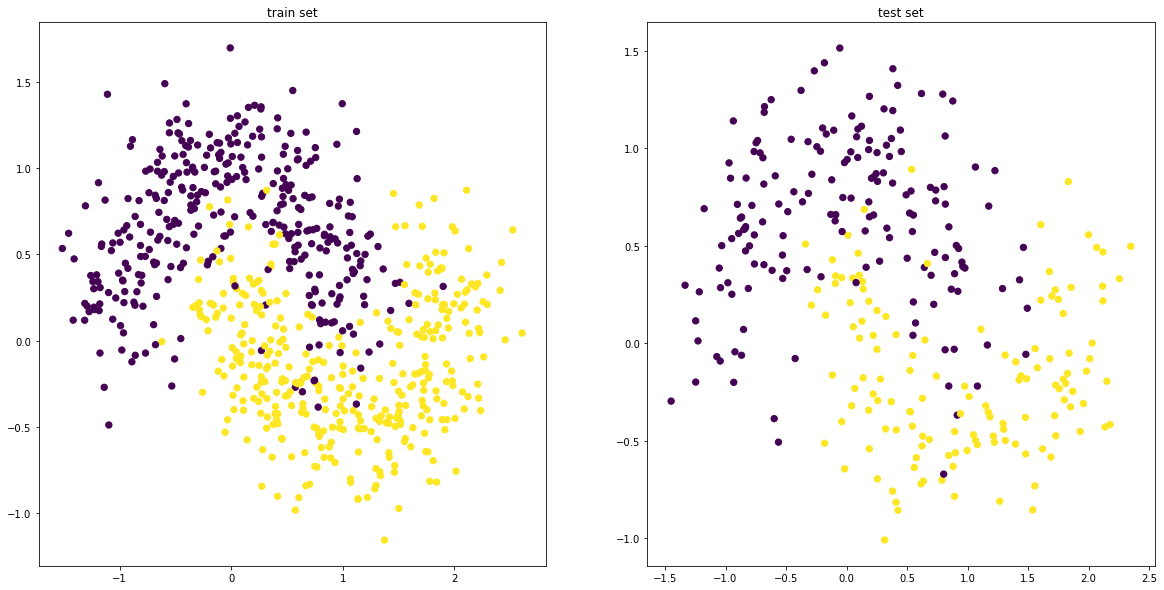

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.title('train set')
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=Y_train)

plt.subplot(1,2,2)
plt.title('test set')
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=Y_test)

## Logistic regression

<font size=3, color="green">__Задание №:9 Логистическая регрессия__</font>

__Необходимо реазлизовать 2 функции:__

- __probability__ отвечающая за реализацию логистической функции потерь

$$L(X,w)=\frac{1}{1+\exp^{(-Xw)}}$$

__Вход:__

- $w$ $-$ значения весов
- $X$ $-$ матрица объект-признак

__Выход:__ массив значений функции потерь, длины $N$. Где $N$ $-$ количество объектов

__________
- __binary_class_prediction__ вызывает функцию __probability__ и на основе ее результата присваивает метки класса по следующей логике: if prob>threshold then 1 else 0

__Выход:__ массив предсказанных меток класса


__!!Важно!!:__ Веса получаем аналитическим методом для из заданий с регрессией


In [33]:
W = least_squares_weights(X_train, Y_train)

In [34]:
def probability(W, X):
    result = 1 / (1 + np.exp(-np.dot(X, W)))
    return result

prob = probability(W, X_train)

#TESTS
assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X_train.shape[0],), 'Неверный размер массива'
assert [round(i,3) for i in prob[[1, -1, 12]]] == [0.451, 0.624, 0.511], 'Функция считается неверно'

In [35]:
def binary_class_prediction(W, X, threshold =.5):
    prob =  probability(W, X)
    result = np.array([1 if i > threshold else 0 for i in prob])
    return result

Y_train_predict = binary_class_prediction(W, X_train)
Y_test_predict = binary_class_prediction(W, X_test)

#TESTS
assert type(Y_train_predict) == np.ndarray, 'Возвращается неверный тип'
assert Y_train_predict.shape == (X_train.shape[0],), 'Неверный размер массива'
assert min(Y_train_predict) == 0, 'Функция считается неверно'
assert max(Y_train_predict) == 1, 'Функция считается неверно'

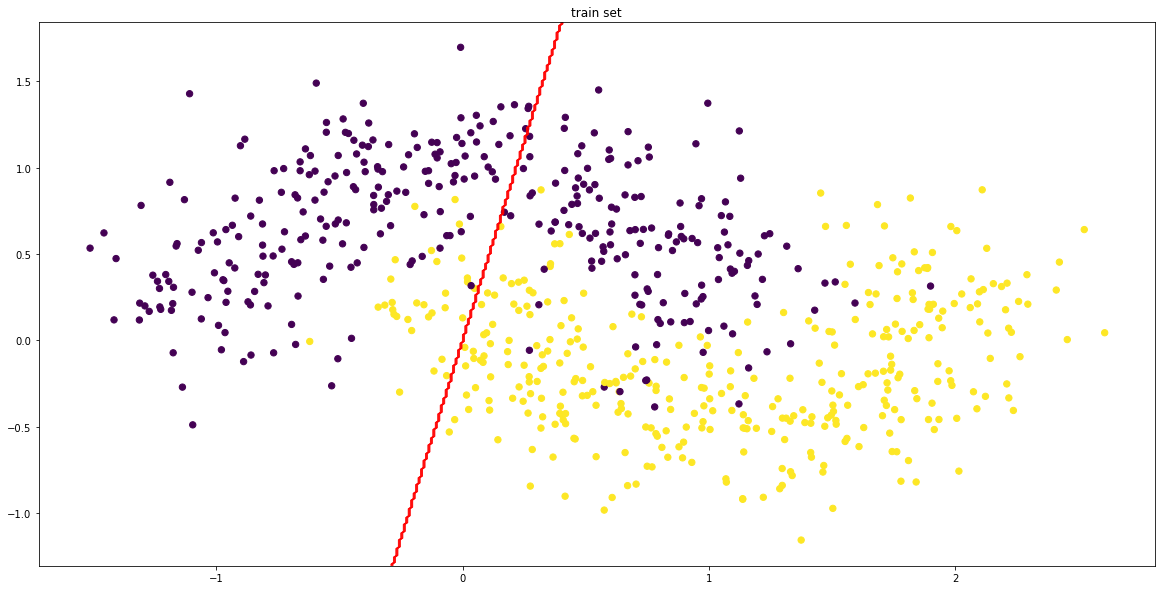

In [36]:
plt.figure(figsize=(20,10))
plt.title('train set')
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=Y_train)

# create grid to evaluate model
x_min, x_max = plt.xlim() 
y_min, y_max = plt.ylim() 
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                     np.arange(y_min, y_max, .01))
Z = binary_class_prediction(W, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors='r', linewidths=0.7)

## Errors

<font size=3, color="green">__Задание №:10 accuracy__</font>

Реализуйте функцию __binary_accuracy__ рассчитывающую долю верно размеченных единиц

__Вход:__

- y_true $-$ истинные метки классов
- y_predict $-$ предсказанные метки классов

__Выход:__ значение от 0 до 1

In [37]:
def binary_accuracy(y_true, y_predict):
    result = (y_true == y_predict).mean()
    return result

assert type(binary_accuracy(Y_train, Y_train_predict)) == np.float64, 'Возвращается неверный тип' 
assert 0<=binary_accuracy(Y_train, Y_train_predict)<=1, 'Результат может принимать значения от 0 до 1'
assert round(binary_accuracy(Y_train, Y_train_predict),2) == 0.75, 'Функция считается неверно'
assert round(binary_accuracy(Y_test, Y_test_predict),2) == 0.71, 'Функция считается неверно'